In [1]:
# Imports

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.transformations.panel.rocket import MiniRocket
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 100)

In [2]:
# Opening up file containing GWAS data and reading in

file = open("Second_GWAS/Second_GWAS_Add.raw", "r")
lines = file.readlines()
len(lines)

110

In [3]:
# Loading GWAS data into DF in the correct format

columns = lines[0].strip("\n").split(" ")
columns = [n.split("_", 1)[0] for n in columns]

df = pd.DataFrame(columns=columns)
data = []

for line in lines[1:]:
    newRow = line.strip("\n").split(" ")
    for position in range(0, len(newRow)):
        if newRow[position] == "0":
            newRow[position] = "2"
        elif newRow[position] == "2":
            newRow[position] = "0"
        
    data.append(newRow)

df = pd.DataFrame(data, columns=columns)

In [4]:
# Checking to see split between cases and controls

df["PHENOTYPE"].value_counts()

1    55
0    54
Name: PHENOTYPE, dtype: int64

In [5]:
# Printing shape of df

df.shape

(109, 41313)

In [6]:
# Printing shape of df

df.columns

Index(['FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE', 'rs7433861',
       'rs1166974', 'rs1166975', 'rs10446372',
       ...
       'rs4030335', 'rs7374010', 'rs9877345', 'rs7373662', 'rs12630742',
       'rs11916265', 'rs7374354', 'rs9325418', 'rs9325420', 'rs10154902'],
      dtype='object', length=41313)

In [7]:
df["PHENOTYPE"] = df["PHENOTYPE"].replace("0","case")
df["PHENOTYPE"] = df["PHENOTYPE"].replace("1","control")

In [8]:
# Dropping columns and seperating phenotype column
phenotype = df.pop("PHENOTYPE")
dfTest = df.drop(columns=["FID","IID","PAT","MAT","SEX"])

In [9]:
# Replacing missing values in df with most common allele for 

imp = SimpleImputer(missing_values="NA", strategy="most_frequent")
idf = pd.DataFrame(imp.fit_transform(dfTest))
idf.columns = dfTest.columns

In [10]:
# Converting columns to be numberical

dfTest = idf.apply(pd.to_numeric)

'case'

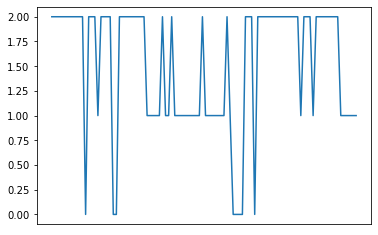

In [11]:
# Visualising first 100 SNPs of first case

dfTranspose = dfTest.T
plt.xticks([])
plt.plot(dfTranspose[0][0:100], color="tab:blue")
phenotype[0]

In [12]:
# Splitting data into training data and testing data

xTrain, xTtest, yTrain, yTest = train_test_split(dfTest, phenotype, train_size=0.7)

In [13]:
# Classifying GWAS data using RandomForest

results = []
for n in range(0,10):
    xTrain, xTtest, yTrain, yTest = train_test_split(dfTest, phenotype, train_size=0.7)
    
    rfc = RandomForestClassifier()
    rfc.fit(xTrain, yTrain)
    
    yPredicted = rfc.predict(xTtest)
    results.append(accuracy_score(yTest, yPredicted))
    
print(f"Average accuracy for RandomForest on entire dataset: {sum(results) / len(results)}")

Average accuracy for RandomForest on entire dataset: 0.5424242424242424


In [14]:
# Converting df to array structure

dfTestSeries = from_2d_array_to_nested(dfTest)

In [15]:
# Splitting time series data into training data and testing data

#xTrain, xTest, yTrain, yTest = train_test_split(dfTestSeries, phenotype, train_size=0.7, random_state=1)

In [16]:
# Extracting values from training split

#yTrain = yTrain.values
#yTest = yTest.values

#xTrain = xTrain.reset_index()
#xTrain = xTrain.drop(columns=["index"])

#xTest = xTest.reset_index()
#xTest = xTest.drop(columns=["index"])

In [17]:
# Classifying GWAS data using MiniRocket

results = []
for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(dfTestSeries, phenotype, train_size=0.7)
    minirocket = MiniRocket()
    minirocket.fit(xTrain)
    xTrainTransform = minirocket.transform(xTrain)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)

    xTestTransform = minirocket.transform(xTest)
    yPredict = classifier.predict(xTestTransform)

    results.append(accuracy_score(yTest, yPredict))
    
print(f"Average accuracy for MiniRocket on entire dataset: {sum(results) / len(results)}")

Average accuracy for MiniRocket on entire dataset: 0.4545454545454545


In [18]:
SNPS = ['rs9867035', 'rs7638693', 'rs9837776', 'rs2873392', 'rs6792542',
       'rs1600058', 'rs1580295', 'rs1316579', 'rs834856', 'rs7430111',
       'rs9817983', 'rs2085079', 'rs834858', 'rs834843', 'rs834864',
       'rs9855684', 'rs1598120', 'rs6445172', 'rs9853565', 'rs1097157']

In [76]:
# Classifying GWAS data using RandomForest

results = []
for n in range(0,10):
    xTrain, xTtest, yTrain, yTest = train_test_split(dfTest[SNPS], phenotype, train_size=0.7)
    
    rfc = RandomForestClassifier()
    rfc.fit(xTrain, yTrain)
    
    yPredicted = rfc.predict(xTtest)
    results.append(accuracy_score(yTest, yPredicted))
    
print(f"Average accuracy for RandomForest on selected SNPs: {sum(results) / len(results)}")

Average accuracy for RandomForest on selected SNPs: 0.8181818181818181


In [20]:
dfTestSeries = from_2d_array_to_nested(dfTest[SNPS])

In [75]:
# Classifying GWAS data using MiniRocket

results = []
for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(dfTestSeries, phenotype, train_size=0.7)
    minirocket = MiniRocket()
    minirocket.fit(xTrain)
    xTrainTransform = minirocket.transform(xTrain)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)

    xTestTransform = minirocket.transform(xTest)
    yPredict = classifier.predict(xTestTransform)

    results.append(accuracy_score(yTest, yPredict))
    
print(f"Average accuracy for MiniRocket on selected SNPs: {sum(results) / len(results)}")

Average accuracy for MiniRocket on selected SNPs: 0.7696969696969698


In [22]:
# Classifying GWAS data using MrSEQL

#ms = MrSEQLClassifier(seql_mode="fs")

#ms.fit(xTrain, yTrain)
#yPredict = ms.predict(xTest)

#print("Accuracy with MrSEQL: %2.3f" % metrics.accuracy_score(yTest, yPredict))
#print(confusion_matrix(yTest, yPredict))
#print(classification_report(yTest, yPredict))

In [28]:
def GenerateWindowsTest(runs, classifierType, windowSize, threshold):

    results = {}
    numberOfWindows = len(dfTest.columns) // windowSize
    
    for k in range(1,runs+1):

        print(f"Run {k}")

        validationScores = []
        testScores = []
        xTrain, xTest, yTrain, yTest = train_test_split(dfTest, phenotype, train_size=0.7)
        xTrainSplit, xValidate, yTrainSplit, yValidate = train_test_split(xTrain, yTrain, train_size=0.7)

        for n in range(0,numberOfWindows):

            if(n%(numberOfWindows//10) == 0 and n != 0):
                print(f"Progress: {round((n/numberOfWindows) * 100)}%")
                
            windowStart = n * windowSize
            windowEnd = windowStart + windowSize
            xTrainWindow = xTrainSplit.iloc[:,windowStart:windowEnd]
            xValidateWindow = xValidate.iloc[:,windowStart:windowEnd]
            
            if classifierType == "MiniRocket":

                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xValidateWindowSeries = from_2d_array_to_nested(xValidateWindow)
                minirocket = MiniRocket()
                minirocket.fit(xTrainWindowSeries)
                xTrainTransform = minirocket.transform(xTrainWindowSeries)
                classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
                classifier.fit(xTrainTransform, yTrainSplit)
                xValidateTransform = minirocket.transform(xValidateWindowSeries)
                score = classifier.score(xValidateTransform, yValidate)
            
            elif  classifierType == "MrSEQL":
                
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xValidateWindowSeries = from_2d_array_to_nested(xValidateWindow)
                ms = MrSEQLClassifier(seql_mode="clf")
                ms.fit(xTrainWindowSeries, yTrainSplit)
                yPredict = ms.predict(xValidateWindowSeries)
                score = metrics.accuracy_score(yValidate, yPredict)
            
            elif classifierType == "RandomForest":
                
                rfc = RandomForestClassifier()
                rfc.fit(xTrainWindow, yTrainSplit)
                yPredict = rfc.predict(xValidateWindow)
                score = metrics.accuracy_score(yValidate, yPredict)
            
            validationScores.append(score)

        windowsAboveThreshold = [n for n in range(len(validationScores)) if validationScores[n] > threshold]
        
        print(f"Window positions from validation with accuracy above threshold for run {k}")
        print(windowsAboveThreshold)

        windowsAboveThresholdAfterTest = []

        for n in windowsAboveThreshold:

            windowStart = n * windowSize
            windowEnd = windowStart + windowSize
            xTrainWindow = xTrain.iloc[:,windowStart:windowEnd]
            xTestWindow = xTest.iloc[:,windowStart:windowEnd]
            
            if classifierType == "MiniRocket":
                
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xTestWindowSeries = from_2d_array_to_nested(xTestWindow)
                minirocket = MiniRocket()
                minirocket.fit(xTrainWindowSeries)
                xTrainTransform = minirocket.transform(xTrainWindowSeries)
                classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
                classifier.fit(xTrainTransform, yTrain)
                xTestTransform = minirocket.transform(xTestWindowSeries)
                score = classifier.score(xTestTransform, yTest)
                
            elif  classifierType == "MrSEQL":
                
                xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
                xTestWindowSeries = from_2d_array_to_nested(xTestWindow)
                ms = MrSEQLClassifier(seql_mode="clf")
                ms.fit(xTrainWindowSeries, yTrain)
                yPredict = ms.predict(xTestWindowSeries)
                score = metrics.accuracy_score(yTest, yPredict)
            
            elif classifierType == "RandomForest":
                
                rfc = RandomForestClassifier()
                rfc.fit(xTrainWindow, yTrain)
                yPredict = rfc.predict(xTestWindow)
                score = metrics.accuracy_score(yTest, yPredict)
                
            testScores.append(score)

                
        windowsAboveThresholdAfterTest = [windowsAboveThreshold[n] for n in range(len(windowsAboveThreshold)) if testScores[n] > threshold]
        
        print(f"Window positions from validation with accuracy above threshold for run {k}")
        print(windowsAboveThresholdAfterTest)

        for window in windowsAboveThresholdAfterTest:
            if window in results:
                results[window] += 1
            else:
                results[window] = 1
                
    sortedResults = sorted(results.items(), key=lambda x: x[1], reverse=True)
    
    updatedKeyResults = {}
    for key, value in results.items():
        newKeyStart = key*windowSize
        newKeyEnd = newKeyStart + windowSize
        updatedKeyResults[f"{newKeyStart}-{newKeyEnd}"] = value
        
    sortedResults = sorted(updatedKeyResults.items(), key=lambda x: x[1], reverse=True)
    return sortedResults

In [56]:
MiniRocketWindows = GenerateWindowsTest(5, "MiniRocket", 50, 0.6)

Run 1
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 69%
Progress: 79%
Progress: 89%
Progress: 99%
Window positions from validation with accuracy above threshold for run 1
[14, 22, 23, 34, 35, 51, 66, 67, 93, 131, 140, 159, 160, 162, 163, 184, 198, 199, 215, 298, 319, 326, 340, 358, 375, 385, 420, 437, 440, 459, 470, 480, 510, 537, 547, 582, 611, 641, 642, 654, 688, 725, 733, 742, 758, 772, 779, 780, 782, 794]
Window positions from validation with accuracy above threshold for run 1
[34, 93, 140, 198, 326, 385, 537, 611, 725, 733, 780]
Run 2
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 69%
Progress: 79%
Progress: 89%
Progress: 99%
Window positions from validation with accuracy above threshold for run 2
[4, 8, 9, 10, 12, 19, 21, 32, 33, 34, 36, 50, 55, 57, 58, 62, 67, 85, 88, 89, 90, 93, 98, 105, 106, 119, 139, 140, 150, 154, 156, 168, 175, 177, 181, 182, 183, 184, 199, 200, 208, 209, 219, 220

In [58]:
MrSEQLWindows = GenerateWindowsTest(5, "MrSEQL", 50, 0.6)
RandomForestWindows = GenerateWindowsTest(5, "RandomForest", 50, 0.6)

Run 1
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 69%
Progress: 79%
Progress: 89%
Progress: 99%
Window positions from validation with accuracy above threshold for run 1
[5, 15, 22, 23, 31, 44, 45, 47, 48, 55, 56, 58, 61, 63, 67, 68, 72, 86, 87, 95, 108, 116, 117, 126, 128, 147, 151, 154, 155, 168, 171, 174, 184, 198, 208, 212, 215, 221, 232, 233, 240, 246, 254, 255, 256, 262, 270, 272, 283, 287, 291, 305, 306, 317, 326, 329, 359, 367, 375, 383, 388, 412, 413, 427, 430, 434, 437, 443, 466, 489, 492, 493, 497, 499, 509, 510, 511, 516, 517, 521, 536, 537, 538, 556, 557, 562, 563, 576, 577, 594, 595, 596, 597, 603, 606, 627, 631, 632, 634, 654, 657, 658, 665, 668, 673, 675, 677, 678, 683, 687, 700, 701, 702, 706, 710, 718, 724, 725, 731, 732, 735, 736, 772, 780, 792, 798, 811, 813, 817, 818, 825]
Window positions from validation with accuracy above threshold for run 1
[198, 240, 256, 326, 359, 437, 493, 654, 657, 702, 724, 780]
Run 2
Progre

Window positions from validation with accuracy above threshold for run 3
[33, 120, 128, 153, 154, 164, 193, 218, 264, 272, 281, 357, 358, 382, 476, 485, 556, 632, 654, 733, 756, 780]
Run 4
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 69%
Progress: 79%
Progress: 89%
Progress: 99%
Window positions from validation with accuracy above threshold for run 4
[0, 9, 16, 31, 38, 39, 49, 52, 55, 56, 57, 58, 59, 68, 81, 89, 90, 91, 93, 97, 118, 120, 125, 131, 139, 147, 157, 158, 160, 161, 164, 168, 174, 175, 179, 182, 183, 184, 193, 198, 199, 207, 216, 218, 219, 222, 242, 246, 247, 283, 287, 289, 300, 301, 302, 307, 313, 318, 319, 322, 328, 333, 335, 357, 358, 359, 360, 369, 397, 407, 417, 424, 440, 442, 457, 462, 464, 466, 470, 475, 500, 510, 511, 512, 538, 539, 540, 557, 558, 560, 566, 575, 577, 578, 586, 587, 588, 589, 593, 600, 609, 612, 613, 617, 620, 625, 630, 631, 636, 641, 642, 648, 650, 654, 655, 657, 660, 668, 686, 687, 688, 692, 694, 695,

In [78]:
MiniRocketWindows

[('1700-1750', 5),
 ('36250-36300', 4),
 ('39000-39050', 4),
 ('1650-1700', 4),
 ('26850-26900', 3),
 ('21500-21550', 3),
 ('16300-16350', 2),
 ('36650-36700', 2),
 ('10000-10050', 2),
 ('15300-15350', 2),
 ('19200-19250', 2),
 ('25500-25550', 2),
 ('31000-31050', 2),
 ('2900-2950', 2),
 ('8300-8350', 2),
 ('4650-4700', 1),
 ('7000-7050', 1),
 ('9900-9950', 1),
 ('19250-19300', 1),
 ('30550-30600', 1),
 ('2850-2900', 1),
 ('5300-5350', 1),
 ('14050-14100', 1),
 ('16750-16800', 1),
 ('18300-18350', 1),
 ('29750-29800', 1),
 ('30850-30900', 1),
 ('32100-32150', 1),
 ('36200-36250', 1),
 ('36750-36800', 1),
 ('38050-38100', 1),
 ('450-500', 1),
 ('6400-6450', 1),
 ('7650-7700', 1),
 ('8200-8250', 1),
 ('11950-12000', 1),
 ('12100-12150', 1),
 ('12150-12200', 1),
 ('14500-14550', 1),
 ('15950-16000', 1),
 ('16400-16450', 1),
 ('17200-17250', 1),
 ('17500-17550', 1),
 ('30700-30750', 1),
 ('32050-32100', 1),
 ('33550-33600', 1),
 ('38600-38650', 1),
 ('39300-39350', 1),
 ('39750-39800', 1),

In [31]:
dfTest.iloc[:, 1700:1800]

,rs2054402,rs6783510,rs2219740,rs28549095,rs6548843,rs1973163,rs7434172,rs12714541,rs1382069,rs6548846,...,rs9877278,rs10460916,rs11127807,rs6806032,rs12486048,rs9860784,rs538361,rs12714558,rs7611473,rs1473624
0,2,2,2,2,2,1,1,1,1,1,...,1,2,1,2,1,1,1,1,1,2
1,2,2,2,2,2,2,2,2,2,2,...,2,1,1,1,1,2,2,2,1,1
2,2,2,2,2,2,1,1,2,2,2,...,2,1,2,1,0,2,1,2,2,2
3,1,1,1,1,1,2,2,2,2,2,...,1,1,1,1,1,2,2,2,1,2
4,1,1,1,1,1,2,2,2,2,2,...,1,2,0,2,2,2,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,1,1,1,1,1,2,2,1,1,1,...,2,1,1,1,1,2,2,2,1,1
105,1,1,1,1,1,2,2,1,1,1,...,1,1,1,1,1,2,2,2,1,2
106,1,1,1,1,1,2,2,1,1,1,...,0,2,0,2,2,2,2,2,0,2
107,1,1,1,1,1,2,2,1,1,1,...,1,1,1,1,1,2,2,2,1,2


In [72]:
# Classifying GWAS data using RandomForest

results = []
for n in range(0,10):
    xTrain, xTtest, yTrain, yTest = train_test_split(dfTest.iloc[:, 1650:1750], phenotype, train_size=0.7)
    
    rfc = RandomForestClassifier()
    rfc.fit(xTrain, yTrain)
    
    yPredicted = rfc.predict(xTtest)
    results.append(accuracy_score(yTest, yPredicted))
    
print(f"Average accuracy for RandomForest on selected SNP window: {sum(results) / len(results)}")

Average accuracy for RandomForest on selected SNP window: 0.7303030303030303


In [74]:
results = []
for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(dfTest.iloc[:, 1650:1750], phenotype, train_size=0.7)

    
    xTrain = from_2d_array_to_nested(xTrain)
    xTest = from_2d_array_to_nested(xTest)
    
    minirocket = MiniRocket()
    minirocket.fit(xTrain)
    xTrainTransform = minirocket.transform(xTrain)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)

    xTestTransform = minirocket.transform(xTest)
    yPredict = classifier.predict(xTestTransform)

    results.append(accuracy_score(yTest, yPredict))
    
print(f"Average accuracy for MiniRocket on selected SNP window: {sum(results) / len(results)}")

Average accuracy for MiniRocket on selected SNP window: 0.7151515151515153
